In [46]:
!pip install torchtext==0.8.1

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [48]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [49]:
# Read csv file
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [50]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [51]:
# Delete unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [52]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
# Renaming the columns
df.columns = ["labels", "data"]
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
# Create binary labels 0 or 1
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [55]:
# Create dataframe with columns needed
df2 = df[['data', 'b_labels']]
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [56]:
# Export new dataframe to a csv
df2.to_csv('spam2.csv', index=False)

In [57]:
# Create TEXT and LABEL fields

TEXT = ttd.Field(sequential=True, batch_first=True, lower=False, pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

# Create Tabular Dataset object
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [58]:
# Splitting dataset to train and test
train_dataset, test_dataset = dataset.split()

In [59]:
TEXT.build_vocab(train_dataset,)

In [60]:
vocab = TEXT.vocab

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [62]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
    batch_sizes=(32, 256), device=device)

In [63]:
# What is the shape of embedding output?
# N x T X D
embed = nn.Embedding(len(vocab), 20).to(device)
for inputs, targets in train_iter:
  out = embed(inputs)
  print("input shape:", inputs.shape, "output shape:", out.shape)
  break

input shape: torch.Size([32, 34]) output shape: torch.Size([32, 34, 20])


In [82]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs
    
    # if inputs is T words
    # then outputs is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):
    # Embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # Note: output of embedding is always (N, T, D)
    # Conv1d expects (N, D, T)

    # Conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # Max pool
    out, _ = torch.max(out, 1)

    # Final dense layer
    out = self.fc(out)
    return out

In [83]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(12529, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [84]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [85]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      # print("outputs.shape:", outputs.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [86]:
# Call the trading function
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 8)

Epoch 1/8, Train Loss: 0.4016,       Test Loss: 0.4293, Duration: 0:00:01.909393
Epoch 2/8, Train Loss: 0.2928,       Test Loss: 0.3350, Duration: 0:00:01.393213
Epoch 3/8, Train Loss: 0.1574,       Test Loss: 0.2662, Duration: 0:00:01.535352
Epoch 4/8, Train Loss: 0.0992,       Test Loss: 0.2868, Duration: 0:00:01.572982
Epoch 5/8, Train Loss: 0.0679,       Test Loss: 0.2776, Duration: 0:00:01.532528
Epoch 6/8, Train Loss: 0.0464,       Test Loss: 0.2114, Duration: 0:00:01.537686
Epoch 7/8, Train Loss: 0.0300,       Test Loss: 0.3011, Duration: 0:00:01.557581
Epoch 8/8, Train Loss: 0.0219,       Test Loss: 0.2436, Duration: 0:00:01.557485


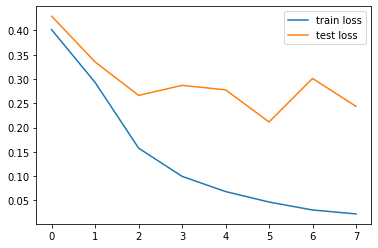

In [87]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [91]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # Update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # Update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9956, Test acc: 0.9169
